--- RUNNING IN FULL MODE ---
Loading simulated data from: ../data/train_v4.hdf5
  - Loaded SNR -30.0: (15000, 16, 120, 7)
  - Loaded SNR -27.5: (15000, 16, 120, 7)
  - Loaded SNR -25.0: (15000, 16, 120, 7)
  - Loaded SNR -22.5: (15000, 16, 120, 7)
  - Loaded SNR -20.0: (15000, 16, 120, 7)
  - Loaded SNR -17.5: (15000, 16, 120, 7)
  - Loaded SNR -15.0: (15000, 16, 120, 7)
  - Loaded SNR -12.5: (15000, 16, 120, 7)
  - Loaded SNR -10.0: (15000, 16, 120, 7)
  - Loaded SNR -7.5: (15000, 16, 120, 7)
  - Loaded SNR -5.0: (15000, 16, 120, 7)
  - Loaded SNR -2.5: (15000, 16, 120, 7)
  - Loaded SNR 0.0: (15000, 16, 120, 7)
  - Loaded SNR 2.5: (15000, 16, 120, 7)
  - Loaded SNR 5.0: (15000, 16, 120, 7)

Loading experimental data from: ../data/experimental_features.hdf5
  - Loaded and Formatted Intensity 30 dB: (5278, 16, 1, 7)
  - Loaded and Formatted Intensity 40 dB: (5257, 16, 1, 7)
  - Loaded and Formatted Intensity 50 dB: (3276, 16, 1, 7)
  - Loaded and Formatted Intensity 60 dB: (1838, 16, 1

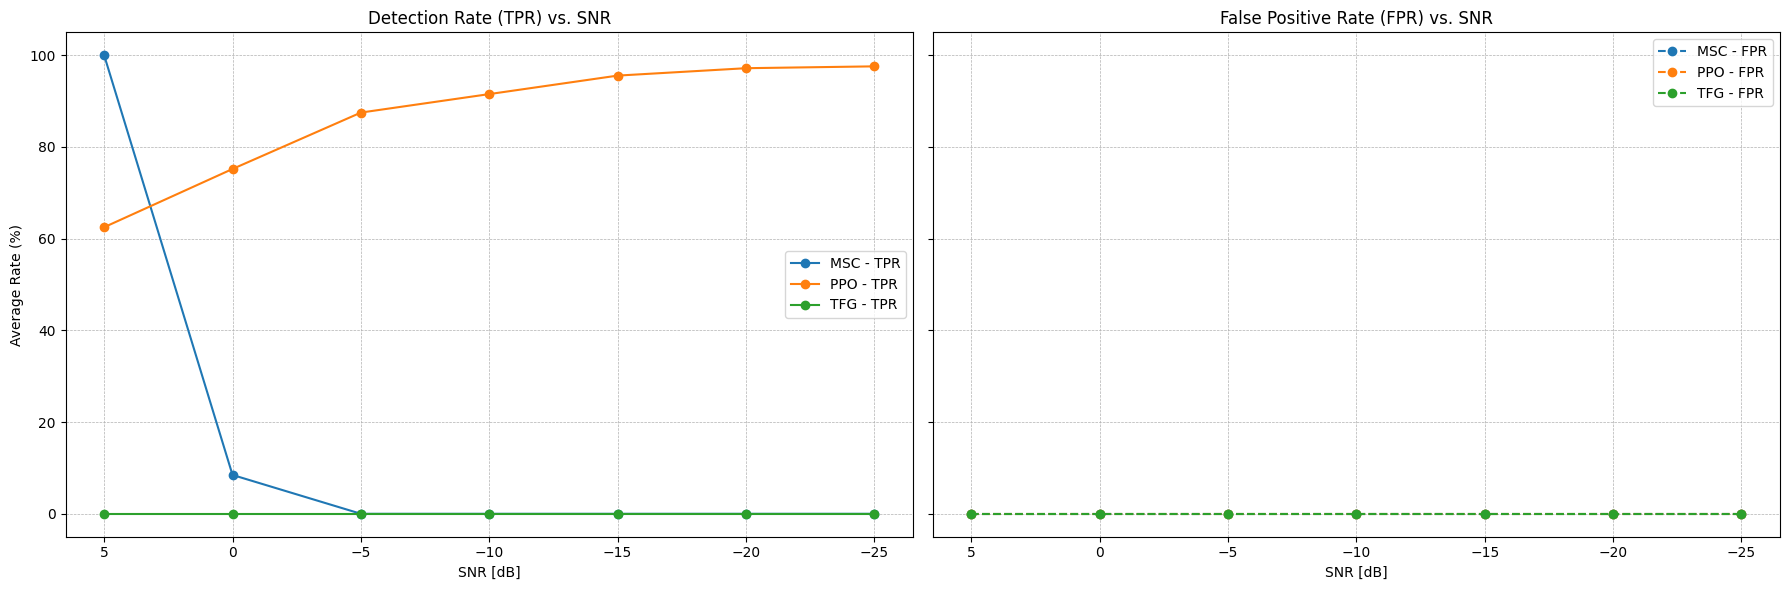

In [ ]:
# -*- coding: utf-8 -*-
"""
Refactored Notebook v22 for PPO Model Training with Dynamic Feature Engineering.

This version re-introduces a dynamic feature engineering pipeline. Instead of
using raw pre-calculated features directly, it uses a FeatureProcessor class
to generate features like moving averages and cumulative sums on-the-fly during
an episode, based on a user-defined FEATURE_CONFIG. The training data is now
a combination of multiple SNRs specified in `snr_train_list`.
"""

# %% [markdown]
# # PPO Model Training with Dynamic Feature Engineering (v22)
#
# # This notebook trains a PPO model using dynamically generated features and handles simulation (4D) and experimental (3D) data, ensuring format consistency.

# %% [code]
# Essential imports
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import matplotlib.pyplot as plt
import h5py
import warnings
import re
from datetime import datetime
from collections import deque

# Ignore some common warnings to keep the output clean
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice.")


# %% [markdown]
# ## Control Parameters

# %% [code]
# #####################################################################
# EXECUTION MODE AND GLOBAL PARAMETERS
# #####################################################################
DRY_RUN = False # Change to False for a full run

if DRY_RUN:
    print("--- RUNNING IN DRY RUN MODE (QUICK TEST) ---")
    TOTAL_TRAINING_TIMESTEPS, EVAL_SIM_TIMESTEPS = 1000, 1000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 5, 10
else:
    print("--- RUNNING IN FULL MODE ---")
    TOTAL_TRAINING_TIMESTEPS, EVAL_SIM_TIMESTEPS = 10000, 1000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 25, 50

# #####################################################################
# DATA CONFIGURATION
# #####################################################################
snr_train_list = [-30.0, -27.5, -25.0, -22.5, -20.0, -17.5, -15.0, -12.5, -10.0, -7.5, -5.0, -2.5, 0.0, 2.5, 5.0] #[-5.0, -2.5, 0.0, 2.5, 5.0]
snr_eval_list =  [-25,-20,-15,-10,-5.0, 0.0,5.0]

# #####################################################################
# PATHS AND CONSTANTS
# #####################################################################
RAW_FEATURE_NAMES = ['MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq']
NUM_SIGNAL_FREQS = 8 # Number of frequencies that contain a signal
MODELS_TO_EVALUATE = ['PPO', 'MSC', 'TFG'] # Models to include in the evaluation

HDF5_SIMULATED_FILEPATH = '../data/train_v4.hdf5'
EXPERIMENTAL_FEATURES_FILE = '../data/experimental_features.hdf5'

# #####################################################################
# FEATURE ENGINEERING CONFIGURATION (USER-ADJUSTABLE)
# #####################################################################
# Define the features and transformations to be used by the agent.
# Format: ('feature_name', 'transform_type', {parameters})
#
# Available Feature Names: 'MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq'
# Special Feature Name: 'timestamp'
#
# Transformation Types:
# - 'simple': The current value of the feature.
# - 'moving_mean': Moving average. Requires {'window_size': N}.
# - 'cumsum': Cumulative sum since the start of the episode.
# - 'cummean': Cumulative mean since the start of the episode.
# #####################################################################
FEATURE_CONFIG = [
    # --- Simple Features (current value) ---
    ('MSC', 'simple', {}),
    ('CSM', 'simple', {}),
    ('TFL', 'simple', {}),
    ('SNR_meas', 'simple', {}),
    ('MAG_freq', 'simple', {}),

    # --- Moving Average Features ---
    ('MSC', 'moving_mean', {'window_size': 18}),
    ('CSM', 'moving_mean', {'window_size': 18}),
    ('TFL', 'moving_mean', {'window_size': 18}),
    ('MAG_freq', 'moving_mean', {'window_size': 18}),

    # --- Cumulative Sum Features ---
    ('MSC', 'cumsum',{}),
    ('CSM', 'cumsum',{}),
    ('TFL', 'cumsum',{}),
    ('MAG_freq', 'cumsum',{}),

    # --- Time Feature ---
    ('timestamp', 'simple', {})
]

# %% [markdown]
# ## Data Loading and Preparation (HDF5)

# %% [code]
def load_and_adapt_hdf5_data(sim_path, exp_path):
    """
    Loads HDF5 data and ensures all output datasets have the 4D format
    (trials, freqs, windows, features).
    """
    simulated_c_states = {}
    experimental_c_states = {}

    print(f"Loading simulated data from: {sim_path}")
    try:
        with h5py.File(sim_path, 'r') as f:
            snr_keys = sorted([key for key in f.keys() if 'snr' in key], key=lambda x: float(x.split('_')[1]))
            for key in snr_keys:
                snr_val = float(key.split('_')[1])
                data_4d = f[key]['metrics'][:]
                simulated_c_states[snr_val] = data_4d.transpose(0, 2, 1, 3)
                print(f"  - Loaded SNR {snr_val}: {simulated_c_states[snr_val].shape}")

    except FileNotFoundError:
        print(f"Warning: Simulated data file '{sim_path}' not found. Training will be skipped.")
    except Exception as e:
        print(f"Error loading simulated data: {e}")


    print(f"\nLoading experimental data from: {exp_path}")
    try:
        with h5py.File(exp_path, 'r') as f:
            temp_experimental_data = {}
            for volunteer in f.keys():
                for intensity_key in f[volunteer].keys():
                    intensity_val_match = re.search(r'(\d+)', intensity_key)
                    if not intensity_val_match: continue
                    intensity_val = int(intensity_val_match.group(1))
                    data = f[volunteer][intensity_key]['metrics'][:]
                    if intensity_val in temp_experimental_data:
                        temp_experimental_data[intensity_val].append(data)
                    else:
                        temp_experimental_data[intensity_val] = [data]

            for intensity, data_list in temp_experimental_data.items():
                combined_data = np.concatenate(data_list, axis=0)
                
                if combined_data.ndim == 3:
                    combined_data = np.expand_dims(combined_data, axis=2)
                
                experimental_c_states[intensity] = combined_data
                print(f"  - Loaded and Formatted Intensity {intensity} dB: {combined_data.shape}")

    except FileNotFoundError:
        print(f"Warning: Experimental data file '{exp_path}' not found. Experimental evaluation will be skipped.")
    except Exception as e:
        print(f"Error loading experimental data: {e}")

    return simulated_c_states, experimental_c_states

simulated_c_states, experimental_c_states = load_and_adapt_hdf5_data(
    HDF5_SIMULATED_FILEPATH, EXPERIMENTAL_FEATURES_FILE
)

def clean_data_dict(data_dict):
    """Replaces NaNs and Infs with 0.0 to prevent training errors."""
    cleaned_dict = {}
    for key, array in data_dict.items():
        if np.isnan(array).any() or np.isinf(array).any():
            print(f"Warning: Cleaning invalid values for key '{key}'.")
            cleaned_dict[key] = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)
        else:
            cleaned_dict[key] = array
    return cleaned_dict

print("\nValidating and cleaning data...")
simulated_c_states = clean_data_dict(simulated_c_states)
experimental_c_states = clean_data_dict(experimental_c_states)
print("Validation complete.")


# %% [markdown]
# ## Feature Engineering and Environments

# %% [code]
# #####################################################################
# ADDED THIS BLOCK TO FIX THE NameError
# #####################################################################
class CustomLoggingCallback(BaseCallback):
    """Callback for custom logs during training."""
    def __init__(self, log_freq: int, verbose=0):
        super().__init__(verbose)
        self.log_freq, self.episode_count = log_freq, 0
    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            self.episode_count += 1
            if self.episode_count % self.log_freq == 0 and self.logger.name_to_value:
                print(f"--- Library Logs (Episode {self.episode_count}) ---")
                for key, value in self.logger.name_to_value.items():
                    print(f"  {key}: {value:.4f}")
                print("---------------------------------------")
        return True
# #####################################################################

class FeatureProcessor:
    """Handles dynamic feature engineering based on a configuration."""
    def __init__(self, raw_feature_names, feature_config):
        self.raw_feature_names = raw_feature_names
        self.config = feature_config
        self.output_size = len(feature_config)
        self.history = {}
        self.cumulative_sums = {}

    def reset(self):
        """Resets the state for a new episode."""
        self.history = {name: deque(maxlen=200) for name in self.raw_feature_names} # Max possible window
        self.cumulative_sums = {name: 0.0 for name in self.raw_feature_names}

    def process(self, raw_features_t, step_idx, total_steps):
        """Calculates the engineered feature vector for the current step."""
        # Update history and cumulative sums
        for i, name in enumerate(self.raw_feature_names):
            self.history[name].append(raw_features_t[i])
            self.cumulative_sums[name] += raw_features_t[i]

        engineered_features = []
        for feat_name, transform, params in self.config:
            if feat_name == 'timestamp':
                engineered_features.append(step_idx / total_steps)
                continue

            # Base value for transformations
            base_value = self.history[feat_name][-1]

            if transform == 'simple':
                engineered_features.append(base_value)
            elif transform == 'moving_mean':
                window = params.get('window_size', 1)
                hist_slice = list(self.history[feat_name])[-window:]
                engineered_features.append(np.mean(hist_slice) if hist_slice else 0.0)
            elif transform == 'cumsum':
                engineered_features.append(self.cumulative_sums[feat_name])
            elif transform == 'cummean':
                engineered_features.append(self.cumulative_sums[feat_name] / (step_idx + 1))
        
        return np.array(engineered_features, dtype=np.float32)

class SignalDetectionEnvBase(gym.Env):
    """Base class for our signal detection environments."""
    def __init__(self, data, feature_processor, verbose_level=0, verbose_freq=10):
        super().__init__()
        self.data = data
        self.feature_processor = feature_processor
        self.verbose_level, self.verbose_freq = verbose_level, verbose_freq
        
        self.num_trials, self.num_steps, _, self.num_raw_features = data.shape
        self.episode_count = -1

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.feature_processor.output_size,), dtype=np.float32
        )
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.current_trial_idx = self._get_next_trial_idx()
        self.current_step = 0
        self.current_trial_data = self.data[self.current_trial_idx]
        self.false_positives, self.true_positives = 0, 0
        self.feature_processor.reset()
        return self._get_state(), {}

    def step(self, action):
        raise NotImplementedError

    def _get_state(self):
        if self.current_step >= self.num_steps:
            return np.zeros(self.feature_processor.output_size, dtype=np.float32)
        
        raw_obs = self.current_trial_data[self.current_step, -1, :]
        engineered_obs = self.feature_processor.process(raw_obs, self.current_step, self.num_steps)
        return engineered_obs

    def _get_next_trial_idx(self):
         return self.episode_count % self.num_trials

class SimTrainingEnv(SignalDetectionEnvBase):
    """Training environment that uses the feature processor."""
    def step(self, action):
        should_detect = self.current_step < NUM_SIGNAL_FREQS
        
        tp = 1 if action == 1 and should_detect else 0
        fp = 1 if action == 1 and not should_detect else 0
        
        tn = 1 if action == 0 and not should_detect else 0
        fn = 1 if action == 0 and should_detect else 0

        if tp: self.true_positives += 1
        if fp: self.false_positives += 1
        
        reward = tp - fp + tn - fn

        self.current_step += 1
        terminated = self.current_step >= self.num_steps
        info = {}

        if terminated:
            num_noise_freqs = self.num_steps - NUM_SIGNAL_FREQS
            tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
            fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
            reward = ((tp_rate / 100) ** 2) - ((fp_rate / 100) ** 2)
            info = {'tp_rate': round(tp_rate, 2), 'fp_rate': round(fp_rate, 2)}

        return self._get_state(), reward, terminated, False, info

class ExpEvaluationEnv(SignalDetectionEnvBase):
    """Evaluation environment that also uses the feature processor."""
    def _get_next_trial_idx(self):
        # In evaluation, we iterate through each trial once
        return (self.episode_count) % self.num_trials

    def step(self, action):
        should_detect = self.current_step < NUM_SIGNAL_FREQS
        if action == 1:
            if should_detect: self.true_positives += 1
            else: self.false_positives += 1
        
        self.current_step += 1
        terminated = self.current_step >= self.num_steps
        reward = 1
        info = self._get_info() if terminated else {}
        return self._get_state(), reward, terminated, False, info

    def _get_info(self):
        num_noise_freqs = self.num_steps - NUM_SIGNAL_FREQS
        tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
        fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
        return {'tp_rate': tp_rate, 'fp_rate': fp_rate}

# %% [markdown]
# # 1. PPO Model Training
# %% [code]
def train_ppo_model(policy, data, timesteps, model_name, v_level, v_freq, log_freq):
    print("--- Training PPO model ---")
    feature_processor = FeatureProcessor(RAW_FEATURE_NAMES, FEATURE_CONFIG)
    env = DummyVecEnv([lambda: SimTrainingEnv(data, feature_processor, v_level, v_freq)])
    
    policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=dict(pi=[64, 64], vf=[64, 64]))
    model = PPO(policy, env, verbose=0, policy_kwargs=policy_kwargs, n_steps=2048)
    model.learn(total_timesteps=timesteps, callback=CustomLoggingCallback(log_freq=log_freq))
    model.save(model_name)
    print(f"Model saved as {model_name}\n")

# Combine data from all specified training SNRs
training_data_list = [simulated_c_states[snr] for snr in snr_train_list if snr in simulated_c_states]
if training_data_list:
    training_data = np.concatenate(training_data_list, axis=0)
    print(f"\nCombined training data from SNRs {snr_train_list}. Total shape: {training_data.shape}")
    train_ppo_model('MlpPolicy', training_data, TOTAL_TRAINING_TIMESTEPS, 'ppo_model.zip', VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ)
else:
    print(f"ERROR: No data found for training SNRs {snr_train_list}. Skipping training.")


# %% [markdown]
# # 2. Unified Evaluation and Plotting

# %% [code]
def run_evaluation_for_model(model_name, env, total_timesteps, ppo_model=None):
    """Runs the evaluation for a given model and environment."""
    tpr_list, fpr_list = [], []
    num_episodes = max(1, total_timesteps // env.num_steps)

    for i in range(num_episodes):
        obs, _ = env.reset()
        terminated = False
        while not terminated:
            if model_name == 'PPO':
                action, _ = ppo_model.predict(obs, deterministic=True)
            else:
                # Placeholder logic uses the 'simple' transformed features
                msc_simple_idx = [i for i, cfg in enumerate(FEATURE_CONFIG) if cfg[0] == 'MSC' and cfg[1] == 'simple']
                tfg_simple_idx = [i for i, cfg in enumerate(FEATURE_CONFIG) if cfg[0] == 'TFG' and cfg[1] == 'simple']
                
                if model_name == 'MSC' and msc_simple_idx:
                    action = 1 if obs[msc_simple_idx[0]] > 0.6 else 0
                elif model_name == 'TFG' and tfg_simple_idx:
                    action = 1 if obs[tfg_simple_idx[0]] > 0.5 else 0
                else:
                    action = 0 # Default action if feature not in config
            
            obs, _, terminated, _, info = env.step(action)
            if terminated:
                if 'tp_rate' in info and not np.isnan(info['tp_rate']):
                    tpr_list.append(info['tp_rate'])
                    fpr_list.append(info['fp_rate'])
    
    if not tpr_list: return np.nan, np.nan
    return np.nanmean(tpr_list), np.nanmean(fpr_list)

def plot_results_from_hdf5(filename):
    """Reads evaluation results from an HDF5 file and plots them."""
    print(f"\n--- Generating plots from {filename} ---")
    with h5py.File(filename, 'r') as hf:
        if "simulated" in hf:
            sim_group = hf["simulated"]
            models = list(sim_group.keys())
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

            for model_name in models:
                if "tpr" in sim_group[model_name]:
                    snrs_str = sorted(sim_group[f'{model_name}/tpr'].keys(), key=float, reverse=True)
                    snrs_num = [float(s) for s in snrs_str]
                    tpr_values = [sim_group[f'{model_name}/tpr/{s}'][()] for s in snrs_str]
                    ax1.plot(snrs_num, tpr_values, 'o-', label=f'{model_name} - TPR')

                if "fpr" in sim_group[model_name]:
                    snrs_str = sorted(sim_group[f'{model_name}/fpr'].keys(), key=float, reverse=True)
                    snrs_num = [float(s) for s in snrs_str]
                    fpr_values = [sim_group[f'{model_name}/fpr/{s}'][()] for s in snrs_str]
                    ax2.plot(snrs_num, fpr_values, 'o--', label=f'{model_name} - FPR')

            ax1.set_title('Detection Rate (TPR) vs. SNR'); ax1.set_xlabel('SNR [dB]'); ax1.set_ylabel('Average Rate (%)')
            ax1.grid(True, which='both', linestyle='--', linewidth=0.5); ax1.legend(); ax1.invert_xaxis()
            ax2.set_title('False Positive Rate (FPR) vs. SNR'); ax2.set_xlabel('SNR [dB]')
            ax2.grid(True, which='both', linestyle='--', linewidth=0.5); ax2.legend(); ax2.invert_xaxis()

            plt.tight_layout()
            plt.savefig('performance_vs_snr_combined.png')
            print("\nPlot 'performance_vs_snr_combined.png' was saved.")
            plt.show()
        else:
            print("No simulated data results found in the file to plot.")

# --- Main Evaluation Block ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_filename = f'results_run_{timestamp}.hdf5'
print(f"\n--- Starting Evaluation Phase ---")
print(f"Results will be saved to: {results_filename}")

try:
    ppo_model = PPO.load('ppo_model.zip')
except FileNotFoundError:
    print("Warning: 'ppo_model.zip' not found. PPO will be skipped in evaluation.")
    ppo_model = None

with h5py.File(results_filename, 'w') as hf:
    # --- Evaluation on SIMULATED Data ---
    if simulated_c_states:
        print("\n--- Evaluating models on SIMULATED data ---")
        sim_group = hf.create_group("simulated")
        
        snr_list_eval_final = snr_eval_list
        if DRY_RUN: snr_list_eval_final = [snr for snr in snr_list_eval_final if snr in [5.0, 0.0, -5.0]]

        for model_name in MODELS_TO_EVALUATE:
            print(f"  Evaluating model: {model_name}")
            if model_name == 'PPO' and not ppo_model:
                print("    - Skipping PPO (model not loaded).")
                continue
            
            model_group = sim_group.create_group(model_name)
            tpr_group = model_group.create_group("tpr")
            fpr_group = model_group.create_group("fpr")

            for snr in snr_list_eval_final:
                if snr not in simulated_c_states:
                    print(f"    - SNR {snr} dB not found in loaded data. Skipping.")
                    continue
                
                feature_processor = FeatureProcessor(RAW_FEATURE_NAMES, FEATURE_CONFIG)
                env_sim = SimTrainingEnv(simulated_c_states[snr], feature_processor)
                tpr, fpr = run_evaluation_for_model(model_name, env_sim, EVAL_SIM_TIMESTEPS, ppo_model=ppo_model)
                print(f"    - SNR {snr} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
                tpr_group.create_dataset(str(snr), data=tpr)
                fpr_group.create_dataset(str(snr), data=fpr)
    
    # --- Evaluation on EXPERIMENTAL Data ---
    if experimental_c_states:
        print("\n--- Evaluating models on EXPERIMENTAL data ---")
        exp_group = hf.create_group("experimental")
        intensity_db_list = sorted(experimental_c_states.keys())
        if DRY_RUN: intensity_db_list = [i for i in intensity_db_list if i in [30, 70]]

        for model_name in MODELS_TO_EVALUATE:
            print(f"  Evaluating model: {model_name}")
            if model_name == 'PPO' and not ppo_model:
                print("    - Skipping PPO (model not loaded).")
                continue

            model_group = exp_group.create_group(model_name)
            tpr_group = model_group.create_group("tpr")
            fpr_group = model_group.create_group("fpr")
            
            for intensity in intensity_db_list:
                exp_data = experimental_c_states[intensity]
                if exp_data.shape[0] > 0:
                    feature_processor = FeatureProcessor(RAW_FEATURE_NAMES, FEATURE_CONFIG)
                    env_exp = ExpEvaluationEnv(exp_data, feature_processor)
                    num_total_steps = exp_data.shape[0] * exp_data.shape[1]
                    tpr, fpr = run_evaluation_for_model(model_name, env_exp, num_total_steps, ppo_model=ppo_model)
                    print(f"    - Intensity {intensity} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
                    tpr_group.create_dataset(str(intensity), data=tpr)
                    fpr_group.create_dataset(str(intensity), data=fpr)
                else:
                    print(f"    - Intensity {intensity} dB -> No data to evaluate.")

# --- Plotting from the saved file ---
plot_results_from_hdf5(results_filename)